In [3]:

!pip install gdown
!mkdir -p ./data/raw
!mkdir -p ./data/processed
!gdown 1mAWwil4vcMBHyADfzO0yjSt1nEeQFhV- -O ../models/train_on_misspell_only_3330
!gdown 1LvqC5r1fkLos_6shhmes1ztRNaERMCeM -O ./predicting_effective_arguments_data.zip
!unzip ./predicting_effective_arguments_data.zip -d ./
!pip install transformers[sentencepiece]

Downloading...
From: https://drive.google.com/uc?id=1LvqC5r1fkLos_6shhmes1ztRNaERMCeM
To: /home/adam/projects/berkeley/w207/project/predicting_effective_arguments/notebooks/predicting_effective_arguments_data.zip
100%|██████████████████████████████████████| 26.3M/26.3M [00:00<00:00, 84.5MB/s]
Archive:  ./predicting_effective_arguments_data.zip
replace ./data/test_berkeley.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [33]:
!gdown 1mAWwil4vcMBHyADfzO0yjSt1nEeQFhV- -O ../models/train_on_misspell_only_3330

Downloading...
From: https://drive.google.com/uc?id=1mAWwil4vcMBHyADfzO0yjSt1nEeQFhV-
To: /home/adam/projects/berkeley/w207/project/predicting_effective_arguments/models/train_on_misspell_only_3330
100%|█████████████████████████████████████████| 736M/736M [00:07<00:00, 101MB/s]


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 26 03:44:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
#!unzip ./data/raw/feedback-prize-effectiveness.zip -d ./data/raw/
#!pip install transformers[sentencepiece]

In [38]:
!pip install pyspellchecker

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os as os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.display import HTML, display
from sklearn.preprocessing import LabelEncoder
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (AdamW, AutoConfig, AutoModel, AutoTokenizer,
                          DataCollatorWithPadding)
import nltk
from spellchecker import SpellChecker
#nltk.download('popular')


# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

LOCAL = True



In [40]:
!python -m nltk.downloader all


/home/adam/anaconda3/envs/ds_env/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/adam/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /home/adam/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/adam/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/adam/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-da

# EDA

In [41]:
#for dirname, _, filenames in os.walk('./data'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [42]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#kaggle competitions download -c feedback-prize-effectiveness
#Use the Kaggle API to download the dataset.
#https://github.com/Kaggle/kaggle-api


data_path = '/kaggle/input/feedback-prize-effectiveness/'
if LOCAL:
    data_path = os.path.join('..','data','')

print(data_path)

../data/


In [43]:
#if in local, unzip
tdf = pd.read_csv(data_path + 'train_berkeley.csv')

In [44]:
#if in local, unzip
df_test = pd.read_csv(data_path + 'test_berkeley.csv')

In [45]:
tdf.head()

,Unnamed: 0,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


#Feature Extraction

In [46]:
#shortcut the following
df3 = pd.read_csv('../data/processed/train_w_extracted_features.csv')

In [47]:
df3.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness', 'comma_count', 'NNP', ',', 'NN', 'VBP',
       'VBG', 'TO', 'VB', 'IN', 'WRB', 'DT', 'VBZ', 'JJ', 'CC', 'EX', 'NNS',
       'VBD', 'PRP', '.', 'VBN', 'RB', 'num_tokens', 'misspelled_count',
       'spell_corrected_discourse_text', 'PRP$', 'MD', 'CD', '``', '''', 'WDT',
       'WP', 'POS', 'NNPS', 'JJR', '(', ')', 'RP', ':', 'JJS', 'RBR', 'WP$',
       'PDT', 'UH', '$', 'RBS', 'FW', '#', 'LS', 'SYM'],
      dtype='object')

In [48]:
""" 
Using Penn Treebank Tagger
https://www.nltk.org/api/nltk.tag.html

"""
part_of_speech_dict = {'CC' : 'Coordinating conjunction',
 'CD' : 'Cardinal number',
 'DT' : 'Determiner',
 'EX' : 'Existential there',
 'FW' : 'Foreign word',
 'IN' : 'Preposition or subordinating conjunction',
 'JJ' : 'Adjective',
 'JJR' : 'Adjective, comparative',
 'JJS' : 'Adjective, superlative',
 'LS' : 'List item marker',
 'MD' : 'Modal',
 'NN' : 'Noun, singular or mass',
 'NNS' : 'Noun, plural',
 'NNP' : 'Proper noun, singular',
 'NNPS' : 'Proper noun, plural',
 'PDT' : 'Predeterminer',
 'POS' : 'Possessive ending',
 'PRP' : 'Personal pronoun',
 'PRP$' : 'Possessive pronoun',
 'RB' : 'Adverb',
 'RBR' : 'Adverb, comparative',
 'RBS' : 'Adverb, superlative',
 'RP' : 'Particle',
 'SYM' : 'Symbol',
 'TO' : 'to',
 'UH' : 'Interjection',
 'VB' : 'Verb, base form',
 'VBD' : 'Verb, past tense',
 'VBG' : 'Verb, gerund or present participle',
 'VBN' : 'Verb, past participle',
 'VBP' : 'Verb, non-3rd person singular present',
 'VBZ' : 'Verb, 3rd person singular present',
 'WDT' : 'Wh-determiner',
 'WP' : 'Wh-pronoun',
 'WP$' : 'Possessive wh-pronoun',
 'WRB' : 'Wh-adverb' }

In [49]:
from collections import Counter
"""tokens = nltk.word_tokenize("The quick brown fox jumped over the lazy dog house.")
text = nltk.Text(tokens)
tags = nltk.pos_tag(text)
print(tags)
counts = Counter(tag for word,tag in tags)
total = sum(counts.values())
proportional_counts = dict((word, round(float(count)/total, 3)) for word,count in counts.items())
print(proportional_counts)
df0 = pd.DataFrame([{'discourse_text': "The quick brown fox jumped over the lazy dog house."}]) #starter frame
"""
#df0 = df.sample(frac=0.001, random_state=7)
df0=tdf

def getProportionalDict(discourseText):
    tokens = nltk.word_tokenize(discourseText)
    text = nltk.Text(tokens)
    tags= nltk.pos_tag(text)
    #print(tags)
    counts = Counter(tag for word,tag in tags)
    total = sum(counts.values())
    
    #token_features = dict((word, round(float(count)/total, 3)) for word,count in counts.items())   #scaled to num of tokens provides greater variance in the corr plot
    token_features = dict((word, count) for word,count in counts.items())   #scaled to num of tokens provides greater variance in the corr plot
    
    
    token_features['num_tokens'] = total    
    misspelled = spell.unknown(tokens)
    #token_features['misspelled_count_scaled'] = round(float((len(misspelled))/ total), 3)
    token_features['misspelled_count'] = len(misspelled) 
    spell_corrected_discourse_text =  [' '.join([spell.correction(w).lower() for w in tokens])]    
    token_features['spell_corrected_discourse_text'] = spell_corrected_discourse_text

    return token_features 
    

#df1 = df0['discourse_text'].apply(lambda x: pd.Series(getProportionalDict(x)))




In [50]:
df4 = tdf.merge(df3)
df_test = df_test.merge(df3)

In [51]:
df_test.columns

Index(['Unnamed: 0', 'discourse_id', 'essay_id', 'discourse_text',
       'discourse_type', 'discourse_effectiveness', 'comma_count', 'NNP', ',',
       'NN', 'VBP', 'VBG', 'TO', 'VB', 'IN', 'WRB', 'DT', 'VBZ', 'JJ', 'CC',
       'EX', 'NNS', 'VBD', 'PRP', '.', 'VBN', 'RB', 'num_tokens',
       'misspelled_count', 'spell_corrected_discourse_text', 'PRP$', 'MD',
       'CD', '``', '''', 'WDT', 'WP', 'POS', 'NNPS', 'JJR', '(', ')', 'RP',
       ':', 'JJS', 'RBR', 'WP$', 'PDT', 'UH', '$', 'RBS', 'FW', '#', 'LS',
       'SYM'],
      dtype='object')

In [52]:
df4[['discourse_text', 'spell_corrected_discourse_text']]

,discourse_text,spell_corrected_discourse_text
0,"Hi, i'm Isaac, i'm going to be writing about h...","['hi , i am isaac , i am going to be writing a..."
1,"On my perspective, I think that the face is a ...","['on my perspective , i think that the face is..."
2,I think that the face is a natural landform be...,['i think that the face is a natural landforms...
3,"If life was on Mars, we would know by now. The...","['if life was on mars , we would know by now ...."
4,People thought that the face was formed by ali...,['people thought that the face was formed by a...
...,...,...
33292,For many people they don't like only asking on...,['for many people they do not like only asking...
33293,also people have different views and opinions ...,['also people have different views and opinion...
33294,Advice is something that can impact a persons ...,['advice is something that can impact a person...
33295,someone can use everything that many people sa...,"[""someone can use everything that many people ..."


In [53]:
tdf.columns

Index(['Unnamed: 0', 'discourse_id', 'essay_id', 'discourse_text',
       'discourse_type', 'discourse_effectiveness'],
      dtype='object')

In [54]:
df4.head()

,Unnamed: 0,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,comma_count,NNP,",",NN,...,RBR,WP$,PDT,UH,$,RBS,FW,#,LS,SYM
0,0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,3,7.0,3.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2,1.0,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,5,2.0,5.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0,1.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training Config

In [55]:
#from https://www.kaggle.com/code/anantgupt/pytorch-feedback-eda-train


CONFIG = {
    "seed": 7,
    "epochs": 5,
    "model_name": "microsoft/deberta-v3-base",
    "train_batch_size": 8,
    "valid_batch_size": 16,
    "max_length": 512,
    "learning_rate": 1e-5,
#     "min_lr": 1e-6,
#     "T_max": 500,
#     "weight_decay": 1e-6,
    "num_classes": 3,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
  }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

TRAIN_DIR = data_path + 'raw/train'
TEST_DIR = data_path + 'raw/train'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def set_seed(seed):
#   for REPRODUCIBILITY.
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [57]:
encoder = LabelEncoder()
df4['discourse_effectiveness_label'] = encoder.fit_transform(df4['discourse_effectiveness'])
df_test['discourse_effectiveness_label'] = encoder.fit_transform(df_test['discourse_effectiveness'])

In [58]:
df4.columns

Index(['Unnamed: 0', 'discourse_id', 'essay_id', 'discourse_text',
       'discourse_type', 'discourse_effectiveness', 'comma_count', 'NNP', ',',
       'NN', 'VBP', 'VBG', 'TO', 'VB', 'IN', 'WRB', 'DT', 'VBZ', 'JJ', 'CC',
       'EX', 'NNS', 'VBD', 'PRP', '.', 'VBN', 'RB', 'num_tokens',
       'misspelled_count', 'spell_corrected_discourse_text', 'PRP$', 'MD',
       'CD', '``', '''', 'WDT', 'WP', 'POS', 'NNPS', 'JJR', '(', ')', 'RP',
       ':', 'JJS', 'RBR', 'WP$', 'PDT', 'UH', '$', 'RBS', 'FW', '#', 'LS',
       'SYM', 'discourse_effectiveness_label'],
      dtype='object')

In [59]:
df4['discourse_effectiveness_label'].describe()

count    33297.000000
mean         0.605520
std          0.767975
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: discourse_effectiveness_label, dtype: float64

In [60]:
class FeedBackDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, data_path):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.data_path = data_path
        self.discourse_text = df['discourse_text'].values
        self.targets = df['discourse_effectiveness_label'].values
        self.essay_id = df['essay_id'].values
        self.commas = df[','].values
        self.num_tokens = df['num_tokens'].values
        self.misspelled_count = df['misspelled_count'].values
        self.interjection = df['UH'].values  #99% missing
        self.possessive_wh_pronoun = df['WP$'].values  #'WP$' : 'Possessive wh-pronoun' (99% missing)
        self.existential_there = df['EX'].values  #Existential There (87% missing)
        self.coordinating_conjunction = df['CC'].values  #(38% missing)

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        discourse_text = self.discourse_text[index]
        essay_path = os.path.join(self.data_path, f"{self.essay_id[index]}.txt")
        essay = open(essay_path, 'r').read()
        text = discourse_text + " " + self.tokenizer.sep_token + " " + essay     #add additional here  XXX CHECK THIS
        

        inputs = self.tokenizer.encode_plus(     
                    text,
                    truncation=True,
                    add_special_tokens=True,
                    max_length=self.max_len
                )
        misspelled_count = self.misspelled_count[index]
        return {
            'input_ids': inputs['input_ids'],             #XXX Confirm this is the result of the vectorization of tokens
            'attention_mask': inputs['attention_mask'],   #XXX What is this?  
            'misspelled_count': torch.tensor(misspelled_count, dtype=torch.int),
            'target': self.targets[index]
        }

In [61]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()  #XXX Effect of this? https://pydrobert-pytorch.readthedocs.io/en/latest/advanced_attention.html
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)   
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)    #bounds sum_mask to have a min of 1e-9
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    
  
class FeedBackModel(nn.Module):
    def __init__(self, model_name):
        super(FeedBackModel, self).__init__()
        self.drop = nn.Dropout(p=0.05)   #https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout

        self.model = AutoModel.from_pretrained(model_name)   #XXX transformer What is this doing? https://huggingface.co/docs/transformers/model_doc/auto
        self.config = AutoConfig.from_pretrained(model_name)   #XXX transformer What is this doing?
        self.mpool = MeanPooling()
        
        self.fc = nn.Sequential(   
            nn.Linear(self.config.hidden_size, 255),            
        )
        self.fc2 =  nn.Linear(256, CONFIG['num_classes'])
        
    def forward(self, ids, mask, misspelled_count):        #overriding Module#forward method: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)         #XXX does this impact the model behavior, or is this used for explainability / interpretability
        out = self.mpool(out.last_hidden_state, mask)   #XXX What is the role of mask here
        
        out = self.drop(out)   #XXX Assuming this is a dropout layer
        out = self.fc(out)
        out = self.drop(out)
        misspelled_count = misspelled_count.view(-1,1)       #Not sure what view is doing here
        merged_output = torch.cat((out, misspelled_count), dim=1)      
        out = self.fc2(merged_output)
        
        return out

In [62]:
def train_one_epoch(model, optimizer, dataloader, device):
    model.train()

    total = 0
    running_loss = 0.0
    correct = 0

    bar = tqdm(dataloader, total=len(dataloader))
    for data in bar:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        misspelled_count = data["misspelled_count"].to(device, dtype=torch.int)
        targets = data["target"].to(device, dtype=torch.long)

        batch_size = ids.size(0)

        outputs = model(ids, mask, misspelled_count)

        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item() * batch_size
        total += batch_size

        _, predictions = outputs.max(1)
        correct += (predictions == targets).float().sum().item()

        epoch_loss = running_loss / total
        acc = correct / total

        bar.set_postfix(Loss=epoch_loss, Accuracy=acc*100)

    return epoch_loss, acc


@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()

    total = 0
    running_loss = 0.0
    correct = 0

    for data in dataloader:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        misspelled_count = data["misspelled_count"].to(device, dtype=torch.int)
        targets = data["target"].to(device, dtype=torch.long)

        batch_size = ids.size(0)

        outputs = model(ids, mask, misspelled_count)

        loss = criterion(outputs, targets)

        running_loss += loss.item() * batch_size
        total += batch_size
        
        _, predictions = outputs.max(1)
        correct += (predictions == targets).float().sum().item()

    epoch_loss = running_loss / total
    acc = correct / total

    print("Validation Loss: {:.4f} Accuracy: {:.2f}%".format(epoch_loss, acc * 100))
    return epoch_loss, acc

In [63]:

def start_training(model, optimizer, device, num_epochs):
    start = time.time()
    best_epoch_loss = np.inf
    history = {"Train Loss": [], "Valid Loss": [], "Train Acc": [], "Valid Acc": []}

    for epoch in range(1, num_epochs + 1):
        print("Epoch: ", epoch)
        train_epoch_loss, train_epoch_acc = train_one_epoch(
            model, optimizer, dataloader=train_loader, device=CONFIG["device"]
        )

        val_epoch_loss, valid_epoch_acc = evaluate(
            model, valid_loader, device=CONFIG["device"]
        )

        history["Train Loss"].append(train_epoch_loss)
        history["Valid Loss"].append(val_epoch_loss)
        history["Train Acc"].append(train_epoch_acc)
        history["Valid Acc"].append(valid_epoch_acc)

        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(
                f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})"
            )
            best_epoch_loss = val_epoch_loss
            best_epoch_acc = valid_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_feedback.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")

        print()

    end = time.time()
    time_elapsed = end - start
    print(
        "Training complete in {:.0f}h {:.0f}m {:.0f}s".format(
            time_elapsed // 3600,
            (time_elapsed % 3600) // 60,
            (time_elapsed % 3600) % 60,
        )
    )
    print(
        "Best Loss: {:.4f} Best Accuracy: {:.2f}".format(
            best_epoch_loss, best_epoch_acc * 100
        )
    )

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [64]:
df_train = df4#.sample(frac=0.8, random_state=7)
#df_valid = df4.drop(df_train.index) 
df_valid = df_test

#reduce for quick feedback / debug
#df_train = df_train.sample(frac=0.02, random_state=7)
#df_valid = df_valid.sample(frac=0.02, random_state=7)

In [65]:
df_valid.columns

Index(['Unnamed: 0', 'discourse_id', 'essay_id', 'discourse_text',
       'discourse_type', 'discourse_effectiveness', 'comma_count', 'NNP', ',',
       'NN', 'VBP', 'VBG', 'TO', 'VB', 'IN', 'WRB', 'DT', 'VBZ', 'JJ', 'CC',
       'EX', 'NNS', 'VBD', 'PRP', '.', 'VBN', 'RB', 'num_tokens',
       'misspelled_count', 'spell_corrected_discourse_text', 'PRP$', 'MD',
       'CD', '``', '''', 'WDT', 'WP', 'POS', 'NNPS', 'JJR', '(', ')', 'RP',
       ':', 'JJS', 'RBR', 'WP$', 'PDT', 'UH', '$', 'RBS', 'FW', '#', 'LS',
       'SYM', 'discourse_effectiveness_label'],
      dtype='object')

In [66]:
train_dataset = FeedBackDataset(
    df_train, tokenizer=CONFIG["tokenizer"], max_length=CONFIG["max_length"], data_path=TRAIN_DIR
)
valid_dataset = FeedBackDataset(
    df_valid, tokenizer=CONFIG["tokenizer"], max_length=CONFIG["max_length"], data_path=TRAIN_DIR
)

collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])  #XXX What is this?  Is it doing more than adding padding?
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["train_batch_size"],
    collate_fn=collate_fn,
    num_workers=2,
    shuffle=True,       #XXX Has impact on the result?  Do we need a seed?
    pin_memory=True,     #XXX Has impact on the result?
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG["valid_batch_size"],
    collate_fn=collate_fn,
    num_workers=2,
    shuffle=False,
    pin_memory=True,
)

In [68]:
#Cleanup memory, in case there were errors
#import gc

#gc.collect()
#torch.cuda.empty_cache()
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [69]:
model = FeedBackModel(CONFIG['model_name'])
model.to(CONFIG['device'])

optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'])
criterion = nn.CrossEntropyLoss()
#model, history = start_training(
#   model, optimizer, device=CONFIG['device'], num_epochs=CONFIG['epochs'])

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
#!mkdir -p ./models
#torch.save(model.state_dict(), './models/train_on_misspell_only_3330')

# Load Model

In [71]:
model = FeedBackModel(CONFIG['model_name'])
#model = FeedBackModel()
torch.load('../models/train_on_misspell_only_3330', map_location=torch.device('cpu'))
model.to(torch.device('cpu'))

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


FeedBackModel(
  (drop): Dropout(p=0.05, inplace=False)
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementw

In [72]:
#discourse_id,Ineffective,Adequate,Effective
#a261b6e14276,0.2,0.6,0.4
test_df = pd.read_csv('./data/raw/test.csv')
test_df.head()

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [73]:
df_valid.columns

Index(['Unnamed: 0', 'discourse_id', 'essay_id', 'discourse_text',
       'discourse_type', 'discourse_effectiveness', 'comma_count', 'NNP', ',',
       'NN', 'VBP', 'VBG', 'TO', 'VB', 'IN', 'WRB', 'DT', 'VBZ', 'JJ', 'CC',
       'EX', 'NNS', 'VBD', 'PRP', '.', 'VBN', 'RB', 'num_tokens',
       'misspelled_count', 'spell_corrected_discourse_text', 'PRP$', 'MD',
       'CD', '``', '''', 'WDT', 'WP', 'POS', 'NNPS', 'JJR', '(', ')', 'RP',
       ':', 'JJS', 'RBR', 'WP$', 'PDT', 'UH', '$', 'RBS', 'FW', '#', 'LS',
       'SYM', 'discourse_effectiveness_label'],
      dtype='object')

In [74]:
df_valid['discourse_type'].unique()

array(['Lead', 'Evidence', 'Claim', 'Concluding Statement', 'Position',
       'Counterclaim', 'Rebuttal'], dtype=object)

# Prediction and Accuracy Reporting

In [76]:
criterion = nn.CrossEntropyLoss()
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer']) 
def runeval(df_, label='unlabeled'):
  print('________' + label + '________')
  df_valid_sample = df_#.sample(n=2)
  valid_dataset2 = FeedBackDataset(
      df_valid_sample, tokenizer=CONFIG["tokenizer"], max_length=CONFIG["max_length"], data_path=TRAIN_DIR
    )
  valid_loader = DataLoader(
      valid_dataset2,
      batch_size=1,
      collate_fn=collate_fn,
      num_workers=2,
      shuffle=False,
      pin_memory=True,
  )
  evaluate(model, valid_loader, torch.device('cpu'))
  print('________________')

discourse = ['Lead', 'Position', 'Claim', 'Evidence', 'Counterclaim', 'Rebuttal', 'Concluding Statement']
for discourse_type in discourse:
  runeval(df_valid.loc[(df_valid['discourse_type'] == discourse_type)], discourse_type) 


labels = ['Adequate', 'Ineffective', 'Effective']
for label in labels:
  runeval(df_valid.loc[(df_valid['discourse_effectiveness'] == label)], label) 

________Lead________
Validation Loss: 1.0695 Accuracy: 52.20%
________________
________Position________
Validation Loss: 1.0148 Accuracy: 69.45%
________________
________Claim________
Validation Loss: 1.0725 Accuracy: 56.73%
________________
________Evidence________
Validation Loss: 1.0795 Accuracy: 47.08%
________________
________Counterclaim________
Validation Loss: 1.0222 Accuracy: 64.38%
________________
________Rebuttal________
Validation Loss: 1.0318 Accuracy: 60.91%
________________
________Concluding Statement________
Validation Loss: 1.0757 Accuracy: 50.96%
________________
________Adequate________
Validation Loss: 0.9214 Accuracy: 88.75%
________________
________Ineffective________
Validation Loss: 1.0725 Accuracy: 19.35%
________________
________Effective________
Validation Loss: 1.3979 Accuracy: 0.00%
________________


In [80]:
labels = ['Ineffective', 'Effective']
for label in labels:
  runeval(df_valid.loc[(df_valid['discourse_effectiveness'] == label)], label) 

________Ineffective________
Validation Loss: 1.0725 Accuracy: 19.35%
________________
________Effective________
Validation Loss: 1.3979 Accuracy: 0.00%
________________


<AxesSubplot:>

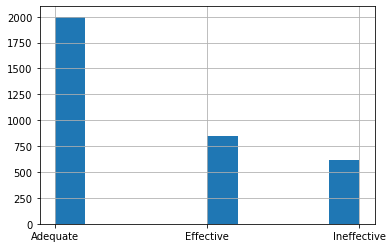

In [79]:
df_valid['discourse_effectiveness'].hist()

In [ ]:
df_valid.shape

(110, 56)

In [ ]:
submission = pd.DataFrame({'discourse_id': test_df.discourse_id, 'Ineffective': 0, 'Adequate': 1, 'Effective': 0})
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)